# CEWA 568 Snow Hydrology - Spring 2023
## Lab 2-1 Short Version

Written by Daniel Hogan - March 9, 2023
Shortened by Jessica Lundquist - April 11, 2023

-----------------------------------------------------
## SNOTEL sites and data within the East River Valley
-----------------------------------------------------

This lab will introduce you to the NRCS SNow TELemetry (SNOTEL) sites (Butte and Schofield Pass) within the East River valley near Crested Butte, CO. We will pull in the SNOTEL data for Butte and Schofield Pass. Once we have this data, we'll add in a few variables and show a plot of snow water equivalent (SWE) for your choice of SNOTEL site and water year. Let's get started!

In [1]:
import xarray as xr # used for storing our data
import matplotlib.pyplot as plt
# import contextily as cx # this is for plotting 
# import geopandas as gpd # for location information of snotel sites
import numpy as np

import pandas as pd
from datetime import datetime
import datetime as dt
import requests


For this lab, we will focus on just the two SNOTEL stations within the East River basin - Butte and Schofield Pass

---------------------------------------------------------------
### Pull in daily SNOTEL SWE, snow depth, and average temperature data
Read more about the NRCS SNOTEL network here: 

https://www.nrcs.usda.gov/wps/portal/wcc/home/aboutUs/monitoringPrograms/automatedSnowMonitoring/#:~:text=Snow%20Telemetry%20(SNOTEL)%20Network,temperature%2C%20and%20other%20climatic%20conditions.

In [2]:
# Build a dictionary with the names and station triplet ids
east_river_sntl_dict = {'Butte':'380:CO:SNTL',
                        'Schofield Pass': '737:CO:SNTL'}
site_ids = list(east_river_sntl_dict.values())

This function will pull in daily SWE (WTEQ), temperature (TAVG) and snow depth (SNWD) for the specified time. It will default to pulling in the full record (going up to yesterday's date). The output will be an xarray dataset with SNOTEL locations and time as dimensions. You can transform this to a pandas dataframe using the `to_dataframe()` method.

In [3]:
# API Domain name
API_DOMAIN = "https://api.snowdata.info/"
def get_awdb_data(
    site_ids,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    server=API_DOMAIN,
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

# Grab dataframes that we want, can add other desired inputs to the function if a shorter time period is desired
sntl_dfs = get_awdb_data(site_ids=site_ids)

# Make the index a datetime
for i,df in enumerate(sntl_dfs):
    df.index = pd.to_datetime(df.index)
    sntl_dfs[i] = df

# create a dictionary for conversion to xarray
sntl_df_dict = {
    site_ids[0]:pd.concat(sntl_dfs[0:3], axis=1).sort_index().to_xarray(),
    site_ids[1]:pd.concat(sntl_dfs[3:6], axis=1).sort_index().to_xarray()
    }



getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-03-27
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-03-27
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-03-27
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-03-27
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-03-27
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-03-27


-----------------------------
### Now we will use the xarray dataset

We'll convert our dataframes to xarray since we will be using xarray for other SOS and atmospheric science data, which use netcdfs (read more about this here: https://docs.xarray.dev/en/stable/)
Think of xarray as a bunch of pandas dataframes stacked on top of eachother into another dimension (this may not help, but that helped me think of how it works)

In [4]:
# convert to xarray
sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
# Add water year variable
sntl_ds = sntl_ds.assign_coords({'WY':sntl_ds.Date.dt.year.where(sntl_ds.Date.dt.month < 10, sntl_ds.Date.dt.year + 1)})

Let's take a quick look at what this looks like:
- We have two dimensions (labeled on top) which we can filter on, Date and Location
- Note: all dimensions are "coordinates", but not all coordinates are dimensions, for example, the WY coordinate depends on the Date dimension, so we cannot filter on it.
- We have 3 variables, the same ones we pulled above: TAVG, SNWD and WTEQ. You can click around to see the values and attributes (the file looking icon), which will have the units that we declared when we pulled the data.

In [5]:
sntl_ds

<xarray.Dataset>
Dimensions:   (Date: 15518, Location: 2)
Coordinates:
  * Date      (Date) datetime64[ns] 1980-10-01 1980-10-02 ... 2023-03-27
  * Location  (Location) object '380:CO:SNTL' '737:CO:SNTL'
    WY        (Date) int64 1981 1981 1981 1981 1981 ... 2023 2023 2023 2023 2023
Data variables:
    TAVG      (Location, Date) float64 nan nan nan nan nan ... 16.7 5.0 7.7 5.0
    SNWD      (Location, Date) float64 nan nan nan nan ... 147.0 141.0 140.0
    WTEQ      (Location, Date) float64 0.0 0.0 0.0 0.0 ... 44.7 45.7 46.0 46.3

We'll also apply some filters to filter out crazy data points

- We're assuming that more than 50 inches of snow does not fall in a day here (hint: it does not, check out record daily snowfalls with this link at different locations: https://www.wunderground.com/cat6/Summary-US-State-Historical-Snowfall-Extremes)
- We're also assuming that temperatures are between -50 F and 110 F and daily difference is less than 50 degrees. The coldest temperature recorded at a nearby weather station since 1977 is -40F (which is also -40C!)


In [6]:
# Apply data filters for bad data
# We're assuming that more than 50 inches of snow does not fall in a day here (hint: it does not, check out record daily snowfalls with this link at different locations:)
sntl_ds['SNWD'] = sntl_ds.where(abs(sntl_ds['SNWD'].diff(dim='Date'))<50)['SNWD']

# We're also assuming that temperatures are between -50 F and 110 F and daily difference is less than 50 degrees. The coldest temeprature recorded at a
# nearby weather station since 1977 is -40F (which is also -40C!)

sntl_ds['TAVG'] = sntl_ds.where((abs(sntl_ds['TAVG'].diff(dim='Date'))<50) & 
                                    (sntl_ds['TAVG']>-50) &
                                    ((sntl_ds['TAVG']<110)))['TAVG']

Let's convert units from imperial to metric units and add them as an attribute

In [7]:
# Unit conversions to centimeters
sntl_ds['SNWD'] = sntl_ds['SNWD']*2.54
sntl_ds['SNWD'] = sntl_ds['SNWD'].assign_attrs({'units':'cm'})

sntl_ds['WTEQ'] = sntl_ds['WTEQ']*2.54
sntl_ds['WTEQ']  = sntl_ds['WTEQ'].assign_attrs({'units':'cm'})

# Unit conversion to degrees Celsius
sntl_ds['TAVG'] =  (sntl_ds['TAVG']-32) * 5/9
sntl_ds['TAVG'] = sntl_ds['TAVG'].assign_attrs({'units':'degC'})

### Filter and plot snow water equivalent for a water year for your station of choice
- Decide what site you want to look at: Butte or Schofield Pass (enter the name inside the quote marks in the site line)
- Change the WY variable to see what it shows (must be a greater water year than the minimum water year printed below)

In [9]:
### USER DECIDES WHICH SITE
site = east_river_sntl_dict['Schofield Pass']
title = list(east_river_sntl_dict.keys())[list(east_river_sntl_dict.values()).index(site)]

print(f'Minimum water year is {sntl_ds.sel(Location=site).WY.to_pandas().min()}')

Minimum water year is 1981


(0.0, 160.448)

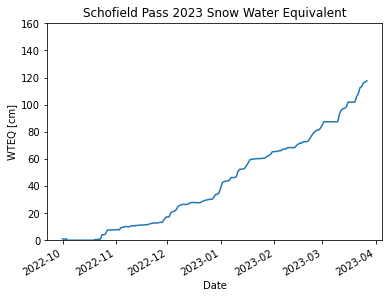

In [11]:
### USER DECIDES WHICH WATER YEAR (needs to be between the start and end data)
WY = 2023

# Filter to our location and our water year and plot
site_wy_swe = sntl_ds.sel(Location=site).where(sntl_ds.WY==WY)['WTEQ']

fig, ax = plt.subplots()
site_wy_swe.plot(ax=ax)
ax.set_title(f'{title} {WY} Snow Water Equivalent')
ax.set_ylim(0,sntl_ds.sel(Location=site)['WTEQ'].max()+5)



Let's see how this year stacks up with the median snow year and plot that too:

In [12]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
# Create an empty array with the same length as the day of water year
dowy = np.zeros(len(sntl_ds.Date.values))
for i,date in enumerate(sntl_ds.Date.values):
    dowy[i] = date2DOWY(date)
# Add this to our dataset
sntl_ds = sntl_ds.assign_coords({'dowy':('Date',dowy)})

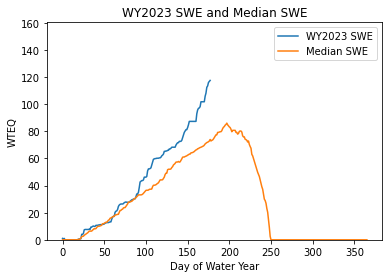

In [13]:
fig, ax = plt.subplots()

ax.plot(sntl_ds.sel(Location=site).where(sntl_ds.WY==WY).dowy,
        sntl_ds.sel(Location=site).where(sntl_ds.WY==WY)['WTEQ'],
        label=f'WY{WY} SWE')

sntl_ds.sel(Location=site).groupby(sntl_ds.dowy).median()['WTEQ'].plot(ax=ax,
                                                                       label='Median SWE')
ax.set_xlabel('Day of Water Year')
ax.set_title(f'WY{WY} SWE and Median SWE')
ax.set_ylim(0,sntl_ds.sel(Location=site)['WTEQ'].max()+5)
ax.legend()